In [9]:
import pandas as pd
import numpy as np
import altair as alt
from typing import Union
import os
from statsmodels.tsa.arima.model import ARIMA #have to pip install this one
import matplotlib.pyplot as plt # To be deleted after we have 
import warnings
warnings.filterwarnings('ignore')

In [34]:
class ErgoAnalysis:
    """
    An analyis of the worldwide energy consumption since 1970.
    The goal is to display the data in various charts and to filter on individual countries or show a comparison between countries. 
        
    Parameters
    ---------------
    df_url: string
        URL to locate the data if not downloaded yet
    df: pd.DataFrame
        Dataframe for storing and analyzin data
    consumption_cols: list
        List of all relevant columns for consumption of energy
    """

    def __init__(self, df_url: str):
        self.df_url = df_url
        self.df = pd.DataFrame()
        self.consumption_cols = [
            "biofuel_consumption",
            "coal_consumption",
            "gas_consumption",
            "hydro_consumption",
            "nuclear_consumption",
            "oil_consumption",
            "other_renewable_consumption",
            "solar_consumption",
            "wind_consumption"
            ]

    def download_data_file(self, download_file: str) -> None:
        """
        Downloads the data file into a downloads/ directory in the root directory of the project (main project directory).
        If the data file already exists, which is found with the attribute df_url, the method will not download it again.
        Reads the dataset into a pandas dataframe which is an attribute of the class and only considers years after 1970, inclusively.

        Parameters
        ---------------
        download_file: str
            URL of the file that should be downloaded if it is not already in the downloads folder

        Returns
        ---------------
        None

        """

        try:
            df = pd.read_csv(f"../downloads/{self.df_url}")

        # If data is not in folder then we will download it from github
        except FileNotFoundError:
            df = pd.read_csv(download_file)

            # Create a new directory if it does not exist
            if not os.path.exists("../downloads/"):
                os.makedirs("../downloads/")
            df.to_csv(f"../downloads/{self.df_url}", index=False)

        finally:
            self.df = df[df["year"] >= 1970].copy()
            self.df["year"] = pd.to_datetime(self.df["year"], format="%Y")
            self.df.set_index("year", inplace=True)
            table_values = [1450,1000,450,455,5.5,1200,0,53,14]
            division = (1*10**9)/(1*10**6)
            self.df['emissions'] = self.df.apply(lambda x: np.nansum((x[self.consumption_cols] * division) * table_values),axis = 1)


    def unique_values(self, column: str = "country", index: bool = False) -> np.ndarray:
        """
        Returns all the unique values in a specific column.

        Parameters
        ---------------
        column: string
            Name of the column to be used.

        index: boolean
            Used to query the index of the dataframe. Is by default False.

        Returns
        ---------------
        final_list: np.ndarray
            Unique numpy array of elements present in column "column" of the attribute of the class called "df".

        """
        # Raise Error if input of user is incorrect
        if not isinstance(column, str):
            raise TypeError("Only strings are allowed as column names")
        if not isinstance(index, bool):
            raise TypeError("Only True or False is allowed for the index value")
        if column not in self.df.columns:
            raise ValueError(f"Column {column} is not in the data set")
        
        # Check if index or a column should be returned
        if index:
            values = self.df.index.unique()
        else:
            values = self.df[column].unique()
        
        return values

    def consumption_sources(self, country: str, normalize: bool = True) -> alt.vegalite.v4.api.Chart:
        """
        Returns a normalized stacked area chart of the "_consumption" columns for a given country.

        Parameters
        ---------------
        country: string
            Country from wich we want to retrieve information.
        normalize: boolean
            Either True if plot to be normalized (%) or False if not to be normalized.

        Returns
        ---------------
        chart: alt.vegalite.v4.api.Chart
            Stacked area chart with the year and total consumption for the selected country.

        """
        # Raise Error if input of user is incorrect
        if not isinstance(country,  str):
            raise TypeError("Only strings are allowed as country names")
        if not isinstance(normalize, bool):
            raise TypeError("Only True or False is allowed")
        if country not in self.unique_values():
            raise ValueError(f"Country {country} is not in the data set")
        
        # Select only consumption columns and year
        country_df = self.df[(self.df["country"] == country)].copy()

        # Turn dataframe from wide to long format
        country_consumption_df = country_df[self.consumption_cols].melt(
            var_name="source", value_name="consumption", ignore_index=False
        )

        # Normalize chart or not
        normalization = "normalize" if normalize else "zero"

        # Get selection of columns for interactive legend of chart
        selection = alt.selection_multi(fields=["source"], bind="legend")

        # Creation of chart with altair
        chart = (
            alt.Chart(country_consumption_df.reset_index())
            .mark_area()
            .encode(
                x=alt.X("year:T", axis=alt.Axis(title="Year")),
                y=alt.Y(
                    "consumption:Q",
                    stack=normalization,
                    axis=alt.Axis(title=f"{'Share' if normalize else 'Amount'} of consumption"),
                ),
                color="source:N",
                opacity=alt.condition(
                    selection, alt.value(1), alt.value(0.2)
                ),  # Changes opacity if source is selected in legend
                tooltip=[
                    alt.Tooltip(title="Source", field="source"),
                    alt.Tooltip(title="Year", field="year", timeUnit="year"),
                    alt.Tooltip(
                        title="Consumption (THh)", field="consumption"
                    ),
                ],
            )
            .properties(
                title=f"Energy Consumption for {country}", width=800, height=300
            )
            .add_selection(selection)
        )

        return chart

    def total_consumption_comparison(self, country_selection: Union[str, list[str]]) -> alt.vegalite.v4.api.Chart:
        """
        Plots the total consumption of one or multiple countries in a line plot.
        All columns with from the attribute consumption_cols will be added up into one number per year and country.

        Parameters
        ---------------
        country_selection: Union[str, list[str]]
            This can either be a single country or a list of countries that will compared

        Returns
        ---------------
        chart: alt.vegalite.v4.api.Chart
            Mutliple line chart with the year and total consumption to compare the selected country or countries

        """
        # Reduce dataframe to selected country/countries
        # Title is for the title in the altair chart
        if isinstance(country_selection, str):
            
            # Raise Error if input of user is incorrect
            if country_selection not in self.unique_values():
                raise ValueError(f"Country {country_selection} is not in the data set")
            
            # If country is in data set, filter data set to the country
            country_df = self.df[self.df["country"] == country_selection].copy()
            title = country_selection
        elif (bool(country_selection) and isinstance(country_selection, list) and all(isinstance(elem, str) for elem in country_selection)):
            
            # Raise Error if input of user is incorrect
            if not any(elem in self.unique_values() for elem in country_selection):
                raise ValueError(f"None of the countries {country_selection} are in the data set")
            
            # If at least one country is in data set, filter data set to the that/those country/countries
            country_df = self.df[self.df["country"].isin(country_selection)].copy()
            title = f"{' vs. '.join(country_selection)}"
        else:
            raise TypeError("Country selection must either be a string or a list of strings")

        # Create total consumption based on all columns ending with "_consumption" and round it by the last 3 digits after comma
        country_df["total_consumption"] = (
            country_df[self.consumption_cols].sum(axis=1).round(3)
        )

        # Get selection of columns for interactive legend of chart
        selection = alt.selection_multi(fields=["country"], bind="legend")

        # Creation of chart with altair
        chart = (
            alt.Chart(country_df.reset_index())
            .mark_line()
            .encode(
                x=alt.X("year:T", axis=alt.Axis(title="Year")),
                y=alt.Y(
                    "total_consumption:Q",
                    axis=alt.Axis(
                        title="Amount of Consumption",
                        labelExpr="datum.value + 'TWh'",
                    ),
                ),
                color="country:N",
                opacity=alt.condition(
                    selection, alt.value(1), alt.value(0.2)
                ),  # Changes opacity if source is selected in legend
                tooltip=[
                    alt.Tooltip(title="Country", field="country"),
                    alt.Tooltip(title="Year", field="year"),
                    alt.Tooltip(
                        title="Consumption in TWh", field="total_consumption"
                    ),
                ],
            )
            .properties(
                title=f"Total consumption for {title}", width=800, height=300
            )
            .add_selection(selection)
        )

        return chart

    def gdp_comparison(self, country_selection: Union[str, list[str]]) -> alt.vegalite.v4.api.Chart:
        """
        Plots the GDP of one or multiple countries in a line plot.

        Parameters
        ---------------
        country_selection: Union[str, list[str]]
            This can either be a single country or a list of countries that will compared

        Returns
        ---------------
        chart: alt.vegalite.v4.api.Chart
            Mutliple line chart with the year and GDP to compare the selected country or countries

        """
        # Reduce dataframe to selected country/countries
        # Title is for the title in the altair chart
        if isinstance(country_selection, str):
            
            # Raise Error if input of user is incorrect
            if country_selection not in self.unique_values():
                raise ValueError(f"Country {country_selection} is not in the data set")
            
            # If country is in data set, filter data set to the country and only get country and gdp
            gdp_df = self.df[self.df["country"] == country_selection][["country", "gdp"]].copy()
            title = country_selection

        # Check if all elements in list are of type str
        elif (bool(country_selection) and isinstance(country_selection, list) and all(isinstance(elem, str) for elem in country_selection)):
            # Raise Error if input of user is incorrect
            if not any(elem in self.unique_values() for elem in country_selection):
                raise ValueError(f"None of the countries {country_selection} are in the data set")
            
            # If at least one country is in data set, filter data set to the that/those country/countries and only get country and gdp
            gdp_df = self.df[self.df["country"].isin(country_selection)][["country", "gdp"]].copy()
            title = f"{' vs. '.join(country_selection)}"
        else:
            raise TypeError("Country selection must either be a string or a list of strings")


        # Get selection of columns for interactive legend of chart
        selection = alt.selection_multi(fields=["country"], bind="legend")

        # Creation of chart with altair
        chart = (
            alt.Chart(gdp_df.reset_index())
            .mark_line()
            .encode(
                x=alt.X("year:T", axis=alt.Axis(title="Year")),
                y=alt.Y(
                    "gdp:Q",
                    axis=alt.Axis(
                        title="GDP value",
                        labelExpr="'$' + datum.value / 1E12 + 'T'",
                    ),
                ),
                color="country:N",
                opacity=alt.condition(
                    selection, alt.value(1), alt.value(0.2)
                ),  # Changes opacity if source is selected in legend
                tooltip=[
                    alt.Tooltip(title="Country", field="country"),
                    alt.Tooltip(title="Year", field="year", timeUnit="year"),
                    alt.Tooltip(title="GDP", field="gdp"),
                ],
            )
            .properties(title=f"GDP of {title}", width=800, height=300)
            .add_selection(selection)
        )

        return chart

    def gapminder(self, year: int, with_world: bool = True) -> alt.vegalite.v4.api.Chart:
        """
        Plots the GDP and total energy consumption of all countries for a specific year.

        Parameters
        ---------------
        year: int
            The year to plot the chart
        with_world: bool
            Have the world as a country in the dataframe or not

        Returns
        ---------------
        chart: alt.vegalite.v4.api.Chart
            Scatter plot of all countries with the GDP as the x-axis and the total energy consumption as the y-axis. The sizes are based on the population size.

        """

        # In case someone enters something else than a string or a list
        if not isinstance(year, int):
            raise TypeError("Year must be an integer")

        # Take out world or not for plot
        if not isinstance(with_world, bool):
            raise TypeError("with_world must be a boolean")

        # In case dataframe did not find selected country show an ouptut message
        if year not in self.unique_values(index = True).year:
            raise ValueError(f"The year {year} has no data in the dataframe")
               
        if with_world:
            world_df = self.df.copy()
        else:
            world_df = self.df[self.df["country"] != "World"].copy()

        # Filter on year
        year_df = world_df[world_df.index.year == year].copy()
        
        # Create columns for plot
        # Population_mil is created for better visibility of the population in plot
        year_df["total_energy_consumption"] = year_df.loc[:, self.consumption_cols].sum(axis=1).round(3)
        year_df["population_mil"] = year_df["population"] / 1000000

        # Get selection of columns for interactive legend of chart
        selection = alt.selection_multi(fields=["country"], bind="legend")

        # Creation of chart with altair
        chart = (
            alt.Chart(year_df)
            .mark_circle()
            .encode(
                x=alt.X(
                    "gdp:Q",
                    axis=alt.Axis(
                        title="GDP", labelExpr="'$' + datum.value/1E9 + 'B'"
                    ),
                    scale=alt.Scale(type="log"),
                ),
                y=alt.Y(
                    "total_energy_consumption:Q",
                    axis=alt.Axis(title="Total Energy Consumption"),
                ),
                color="country:N",
                size=alt.Size("population_mil"),
                opacity=alt.condition(
                    selection, alt.value(1), alt.value(0.2)
                ),  # Changes opacity if source is selected in legend
                tooltip=[
                    alt.Tooltip(title="Country", field="country"),
                    alt.Tooltip(
                        title="Total Energy Consumption",
                        field="total_energy_consumption",
                    ),
                    alt.Tooltip(title="GDP", field="gdp"),
                ],
            )
            .properties(title=f"Gapminder plot of {year}", width=800, height=300)
            .add_selection(selection)
            .interactive()
        )

        return chart

    #emissions and consumption    
    def gapminder_emissions(self, year: int, with_world: bool = True) -> alt.vegalite.v4.api.Chart:
        """
        Plots the emissions and total energy consumption of all countries for a specific year

        Parameters
        ---------------
        year: int
            The year to plot the chart
        with_world: bool
            Have the world as a country in the dataframe or not
            
        Returns
        ---------------
        chart: alt.vegalite.v4.api.Chart
            Scatter plot of all countries with the emissions as the x-axis and the total energy consumption as the y-axis. The sizes are based on the population size.
        
        """
        
        # In case someone enters something else than a string or a list
        if type(year) != int:
            raise TypeError("Year must be an integer")
    
        # Take out world or not for plot
        if type(with_world) != bool:
            raise TypeError("with_world must be a boolean")
        
        if with_world:
            world_df = self.df.copy()
        else:
            world_df = self.df[self.df["country"] != "World"].copy()
        
        # Filter on year
        year_df = world_df[world_df.index.year == year].copy()
        
        # In case dataframe did not find selected country show an ouptut message
        if year_df.empty:
                raise ValueError("The input has no data in the dataframe")
        else:
            # Create columns for plot
            # Population_mil is created for better visibility of the population in plot
            year_df["total_energy_consumption"] = year_df.loc[:, self.consumption_cols].sum(axis=1).round(3)
            year_df["population_mil"] = year_df["population"]/1000000

            # Get selection of columns for interactive legend of chart        
            selection = alt.selection_multi(fields=['country'], bind='legend')
                            
            # Creation of chart with altair
            chart = alt.Chart(year_df).mark_circle().encode(
                x=alt.X('emissions:Q', axis=alt.Axis(title="Emissions"),scale=alt.Scale(type='symlog')),
                y=alt.Y("total_energy_consumption:Q", axis=alt.Axis(title="Total Energy Consumption"),scale=alt.Scale(type='symlog')),
                color="country:N",
                size=alt.Size('population_mil'),
                opacity=alt.condition(selection, alt.value(1), alt.value(0.2)), #Changes opacity if source is selected in legend
                tooltip=[
                    alt.Tooltip(title="Country", field="country"),
                    alt.Tooltip(title="Total Energy Consumption", field="total_energy_consumption"),
                    alt.Tooltip(title="Emissions", field="emissions"),
                ]
                ).properties(
                    title=f"Emissions-Energy Consumption plot of {year}",
                    width=800,
                    height=300
                ) .add_selection(
                    selection
                ).interactive()
            
            return chart
        
    def arima(self, country: str, ad_points: int) -> alt.vegalite.v4.api.Chart:
        """
        Returns two plots.
        
        One for an ARIMA prediction on total energy consumption and another for an ARIMA prediction
        for total emissions. 
        
        Parameters
        ---------------
        country: string
            Name of the country to use when plotting.
        
        ad_points: int
            Number of predicted years.
            
        Returns
        ---------------
        chart: alt.vegalite.v4.api.Chart
            Two line charts with the year and total predicted consumption and total predicted emissions for the selected country, side by side.
        
        """
    
        if ad_points < 1:
            raise ValueError("Number of years can not be less than 1")

        arima_df = self.df.copy()
        arima_df['total_consumption'] = arima_df[self.consumption_cols].sum(axis=1).round(3)
        
        offset = 2
        
        #model consumption
        data_consumption = arima_df[arima_df['country'] == country]['total_consumption'].copy()
        
        start = len(data_consumption) - offset
        end = len(data_consumption) + ad_points -1 + offset
        
        model = ARIMA(data_consumption.iloc[:-offset], order=(3, 1, 0))
        model_fit = model.fit()

        yhat = model_fit.predict(start, end, typ = 'levels')

        #plot   
        data_consumption[:-offset].plot()
        yhat.plot()
        plt.title(f'Consumption for {country}')
        plt.show()
        #-------------------------------------------------------
        #model emissions
        data_emissions = arima_df[arima_df['country'] == country]['emissions'].copy()
        
        start = len(data_emissions) - offset
        end = len(data_emissions) + ad_points -1 + offset

        model = ARIMA(data_emissions.iloc[:-offset], order=(3, 1, 0))
        model_fit = model.fit()

        yhat = model_fit.predict(start, end, typ = 'levels')

        #------------------------------------------
        data_emissions[:-offset].plot()
        yhat.plot()
        plt.title(f'Emissions for {country}')
        plt.show()


In [154]:
class ErgoAnalysis:
    """
    An analyis of the worldwide energy consumption since 1970.
    The goal is to display the data in various charts and to filter on individual countries or show a comparison between countries. 
        
    Parameters
    ---------------
    df_url: string
        URL to locate the data if not downloaded yet
    df: pd.DataFrame
        Dataframe for storing and analyzin data
    consumption_cols: list
        List of all relevant columns for consumption of energy
    """

    def __init__(self, df_url: str):
        self.df_url = df_url
        self.df = pd.DataFrame()
        self.consumption_cols = [
            "biofuel_consumption",
            "coal_consumption",
            "gas_consumption",
            "hydro_consumption",
            "nuclear_consumption",
            "oil_consumption",
            "other_renewable_consumption",
            "solar_consumption",
            "wind_consumption"
            ]

    def download_data_file(self, download_file: str) -> None:
        """
        Downloads the data file into a downloads/ directory in the root directory of the project (main project directory).
        If the data file already exists, which is found with the attribute df_url, the method will not download it again.
        Reads the dataset into a pandas dataframe which is an attribute of the class and only considers years after 1970, inclusively.

        Parameters
        ---------------
        download_file: str
            URL of the file that should be downloaded if it is not already in the downloads folder

        Returns
        ---------------
        None

        """

        try:
            df = pd.read_csv(f"../downloads/{self.df_url}")

        # If data is not in folder then we will download it from github
        except FileNotFoundError:
            df = pd.read_csv(download_file)

            # Create a new directory if it does not exist
            if not os.path.exists("../downloads/"):
                os.makedirs("../downloads/")
            df.to_csv(f"../downloads/{self.df_url}", index=False)

        finally:
            self.df = df[df["year"] >= 1970].copy()
            self.df["year"] = pd.to_datetime(self.df["year"], format="%Y")
            self.df.set_index("year", inplace=True)
            table_values = [1450,1000,450,455,5.5,1200,0,53,14]
            division = (1*10**9)/(1*10**6)
            self.df['emissions'] = self.df.apply(lambda x: np.nansum((x[self.consumption_cols] * division) * table_values),axis = 1)


    def unique_values(self, column: str = "country", index: bool = False) -> np.ndarray:
        """
        Returns all the unique values in a specific column.

        Parameters
        ---------------
        column: string
            Name of the column to be used.

        index: boolean
            Used to query the index of the dataframe. Is by default False.

        Returns
        ---------------
        final_list: np.ndarray
            Unique numpy array of elements present in column "column" of the attribute of the class called "df".

        """
        # Raise Error if input of user is incorrect
        if not isinstance(column, str):
            raise TypeError("Only strings are allowed as column names")
        if not isinstance(index, bool):
            raise TypeError("Only True or False is allowed for the index value")
        if column not in self.df.columns:
            raise ValueError(f"Column {column} is not in the data set")
        
        # Check if index or a column should be returned
        if index:
            values = self.df.index.unique()
        else:
            values = self.df[column].unique()
        
        return values

    def consumption_sources(self, country: str, normalize: bool = True) -> alt.vegalite.v4.api.Chart:
        """
        Returns a normalized stacked area chart of the "_consumption" columns for a given country.

        Parameters
        ---------------
        country: string
            Country from wich we want to retrieve information.
        normalize: boolean
            Either True if plot to be normalized (%) or False if not to be normalized.

        Returns
        ---------------
        chart: alt.vegalite.v4.api.Chart
            Stacked area chart with the year and total consumption for the selected country.

        """
        # Raise Error if input of user is incorrect
        if not isinstance(country,  str):
            raise TypeError("Only strings are allowed as country names")
        if not isinstance(normalize, bool):
            raise TypeError("Only True or False is allowed")
        if country not in self.unique_values():
            raise ValueError(f"Country {country} is not in the data set")
        
        # Select only consumption columns and year
        country_df = self.df[(self.df["country"] == country)].copy()

        # Turn dataframe from wide to long format
        country_consumption_df = country_df[self.consumption_cols].melt(
            var_name="source", value_name="consumption", ignore_index=False
        )

        # Normalize chart or not
        normalization = "normalize" if normalize else "zero"

        # Get selection of columns for interactive legend of chart
        selection = alt.selection_multi(fields=["source"], bind="legend")

        # Creation of chart with altair
        chart = (
            alt.Chart(country_consumption_df.reset_index())
            .mark_area()
            .encode(
                x=alt.X("year:T", axis=alt.Axis(title="Year")),
                y=alt.Y(
                    "consumption:Q",
                    stack=normalization,
                    axis=alt.Axis(title=f"{'Share' if normalize else 'Amount'} of consumption"),
                ),
                color="source:N",
                opacity=alt.condition(
                    selection, alt.value(1), alt.value(0.2)
                ),  # Changes opacity if source is selected in legend
                tooltip=[
                    alt.Tooltip(title="Source", field="source"),
                    alt.Tooltip(title="Year", field="year", timeUnit="year"),
                    alt.Tooltip(
                        title="Consumption (THh)", field="consumption"
                    ),
                ],
            )
            .properties(
                title=f"Energy Consumption for {country}", width=800, height=300
            )
            .add_selection(selection)
        )

        return chart

    def total_consumption_comparison(self, country_selection: Union[str, list[str]]) -> alt.vegalite.v4.api.Chart:
        """
        Plots the total consumption of one or multiple countries in a line plot.
        All columns with from the attribute consumption_cols will be added up into one number per year and country.

        Parameters
        ---------------
        country_selection: Union[str, list[str]]
            This can either be a single country or a list of countries that will compared

        Returns
        ---------------
        chart: alt.vegalite.v4.api.Chart
            Mutliple line chart with the year and total consumption to compare the selected country or countries

        """
        # Reduce dataframe to selected country/countries
        # Title is for the title in the altair chart
        if isinstance(country_selection, str):
            
            # Raise Error if input of user is incorrect
            if country_selection not in self.unique_values():
                raise ValueError(f"Country {country_selection} is not in the data set")
            
            # If country is in data set, filter data set to the country
            country_df = self.df[self.df["country"] == country_selection].copy()
            title = country_selection
        elif (bool(country_selection) and isinstance(country_selection, list) and all(isinstance(elem, str) for elem in country_selection)):
            
            # Raise Error if input of user is incorrect
            if not any(elem in self.unique_values() for elem in country_selection):
                raise ValueError(f"None of the countries {country_selection} are in the data set")
            
            # If at least one country is in data set, filter data set to the that/those country/countries
            country_df = self.df[self.df["country"].isin(country_selection)].copy()
            title = f"{' vs. '.join(country_selection)}"
        else:
            raise TypeError("Country selection must either be a string or a list of strings")

        # Create total consumption based on all columns ending with "_consumption" and round it by the last 3 digits after comma
        country_df["total_consumption"] = (
            country_df[self.consumption_cols].sum(axis=1).round(3)
        )

        # Get selection of columns for interactive legend of chart
        selection = alt.selection_multi(fields=["country"], bind="legend")

        # Creation of chart with altair
        chart = (
            alt.Chart(country_df.reset_index())
            .mark_line()
            .encode(
                x=alt.X("year:T", axis=alt.Axis(title="Year")),
                y=alt.Y(
                    "total_consumption:Q",
                    axis=alt.Axis(
                        title="Amount of Consumption",
                        labelExpr="datum.value + 'TWh'",
                    ),
                ),
                color="country:N",
                opacity=alt.condition(
                    selection, alt.value(1), alt.value(0.2)
                ),  # Changes opacity if source is selected in legend
                tooltip=[
                    alt.Tooltip(title="Country", field="country"),
                    alt.Tooltip(title="Year", field="year"),
                    alt.Tooltip(
                        title="Consumption in TWh", field="total_consumption"
                    ),
                ],
            )
            .properties(
                title=f"Total consumption for {title}", width=800, height=300
            )
            .add_selection(selection)
        )

        return chart

    def gdp_comparison(self, country_selection: Union[str, list[str]]) -> alt.vegalite.v4.api.Chart:
        """
        Plots the GDP of one or multiple countries in a line plot.

        Parameters
        ---------------
        country_selection: Union[str, list[str]]
            This can either be a single country or a list of countries that will compared

        Returns
        ---------------
        chart: alt.vegalite.v4.api.Chart
            Mutliple line chart with the year and GDP to compare the selected country or countries

        """
        # Reduce dataframe to selected country/countries
        # Title is for the title in the altair chart
        if isinstance(country_selection, str):
            
            # Raise Error if input of user is incorrect
            if country_selection not in self.unique_values():
                raise ValueError(f"Country {country_selection} is not in the data set")
            
            # If country is in data set, filter data set to the country and only get country and gdp
            gdp_df = self.df[self.df["country"] == country_selection][["country", "gdp"]].copy()
            title = country_selection

        # Check if all elements in list are of type str
        elif (bool(country_selection) and isinstance(country_selection, list) and all(isinstance(elem, str) for elem in country_selection)):
            # Raise Error if input of user is incorrect
            if not any(elem in self.unique_values() for elem in country_selection):
                raise ValueError(f"None of the countries {country_selection} are in the data set")
            
            # If at least one country is in data set, filter data set to the that/those country/countries and only get country and gdp
            gdp_df = self.df[self.df["country"].isin(country_selection)][["country", "gdp"]].copy()
            title = f"{' vs. '.join(country_selection)}"
        else:
            raise TypeError("Country selection must either be a string or a list of strings")


        # Get selection of columns for interactive legend of chart
        selection = alt.selection_multi(fields=["country"], bind="legend")

        # Creation of chart with altair
        chart = (
            alt.Chart(gdp_df.reset_index())
            .mark_line()
            .encode(
                x=alt.X("year:T", axis=alt.Axis(title="Year")),
                y=alt.Y(
                    "gdp:Q",
                    axis=alt.Axis(
                        title="GDP value",
                        labelExpr="'$' + datum.value / 1E12 + 'T'",
                    ),
                ),
                color="country:N",
                opacity=alt.condition(
                    selection, alt.value(1), alt.value(0.2)
                ),  # Changes opacity if source is selected in legend
                tooltip=[
                    alt.Tooltip(title="Country", field="country"),
                    alt.Tooltip(title="Year", field="year", timeUnit="year"),
                    alt.Tooltip(title="GDP", field="gdp"),
                ],
            )
            .properties(title=f"GDP of {title}", width=800, height=300)
            .add_selection(selection)
        )

        return chart

    def gapminder(self, year: int, with_world: bool = True) -> alt.vegalite.v4.api.Chart:
        """
        Plots the GDP and total energy consumption of all countries for a specific year.

        Parameters
        ---------------
        year: int
            The year to plot the chart
        with_world: bool
            Have the world as a country in the dataframe or not

        Returns
        ---------------
        chart: alt.vegalite.v4.api.Chart
            Scatter plot of all countries with the GDP as the x-axis and the total energy consumption as the y-axis. The sizes are based on the population size.

        """

        # In case someone enters something else than a string or a list
        if not isinstance(year, int):
            raise TypeError("Year must be an integer")

        # Take out world or not for plot
        if not isinstance(with_world, bool):
            raise TypeError("with_world must be a boolean")

        # In case dataframe did not find selected country show an ouptut message
        if year not in self.unique_values(index = True).year:
            raise ValueError(f"The year {year} has no data in the dataframe")
               
        if with_world:
            world_df = self.df.copy()
        else:
            world_df = self.df[self.df["country"] != "World"].copy()

        # Filter on year
        year_df = world_df[world_df.index.year == year].copy()
        
        # Create columns for plot
        # Population_mil is created for better visibility of the population in plot
        year_df["total_energy_consumption"] = year_df.loc[:, self.consumption_cols].sum(axis=1).round(3)
        year_df["population_mil"] = year_df["population"] / 1000000

        # Get selection of columns for interactive legend of chart
        selection = alt.selection_multi(fields=["country"], bind="legend")

        # Creation of chart with altair
        chart = (
            alt.Chart(year_df)
            .mark_circle()
            .encode(
                x=alt.X(
                    "gdp:Q",
                    axis=alt.Axis(
                        title="GDP", labelExpr="'$' + datum.value/1E9 + 'B'"
                    ),
                    scale=alt.Scale(type="log"),
                ),
                y=alt.Y(
                    "total_energy_consumption:Q",
                    axis=alt.Axis(title="Total Energy Consumption"),
                ),
                color="country:N",
                size=alt.Size("population_mil"),
                opacity=alt.condition(
                    selection, alt.value(1), alt.value(0.2)
                ),  # Changes opacity if source is selected in legend
                tooltip=[
                    alt.Tooltip(title="Country", field="country"),
                    alt.Tooltip(
                        title="Total Energy Consumption",
                        field="total_energy_consumption",
                    ),
                    alt.Tooltip(title="GDP", field="gdp"),
                ],
            )
            .properties(title=f"Gapminder plot of {year}", width=800, height=300)
            .add_selection(selection)
            .interactive()
        )

        return chart

    #emissions and consumption    
    def gapminder_emissions(self, year: int, with_world: bool = True) -> alt.vegalite.v4.api.Chart:
        """
        Plots the emissions and total energy consumption of all countries for a specific year

        Parameters
        ---------------
        year: int
            The year to plot the chart
        with_world: bool
            Have the world as a country in the dataframe or not
            
        Returns
        ---------------
        chart: alt.vegalite.v4.api.Chart
            Scatter plot of all countries with the emissions as the x-axis and the total energy consumption as the y-axis. The sizes are based on the population size.
        
        """
        
        # In case someone enters something else than a string or a list
        if type(year) != int:
            raise TypeError("Year must be an integer")
    
        # Take out world or not for plot
        if type(with_world) != bool:
            raise TypeError("with_world must be a boolean")
        
        if with_world:
            world_df = self.df.copy()
        else:
            world_df = self.df[self.df["country"] != "World"].copy()
        
        # Filter on year
        year_df = world_df[world_df.index.year == year].copy()
        
        # In case dataframe did not find selected country show an ouptut message
        if year_df.empty:
                raise ValueError("The input has no data in the dataframe")
        else:
            # Create columns for plot
            # Population_mil is created for better visibility of the population in plot
            year_df["total_energy_consumption"] = year_df.loc[:, self.consumption_cols].sum(axis=1).round(3)
            year_df["population_mil"] = year_df["population"]/1000000

            # Get selection of columns for interactive legend of chart        
            selection = alt.selection_multi(fields=['country'], bind='legend')
                            
            # Creation of chart with altair
            chart = alt.Chart(year_df).mark_circle().encode(
                x=alt.X('emissions:Q', axis=alt.Axis(title="Emissions"),scale=alt.Scale(type='symlog')),
                y=alt.Y("total_energy_consumption:Q", axis=alt.Axis(title="Total Energy Consumption"),scale=alt.Scale(type='symlog')),
                color="country:N",
                size=alt.Size('population_mil'),
                opacity=alt.condition(selection, alt.value(1), alt.value(0.2)), #Changes opacity if source is selected in legend
                tooltip=[
                    alt.Tooltip(title="Country", field="country"),
                    alt.Tooltip(title="Total Energy Consumption", field="total_energy_consumption"),
                    alt.Tooltip(title="Emissions", field="emissions"),
                ]
                ).properties(
                    title=f"Emissions-Energy Consumption plot of {year}",
                    width=800,
                    height=300
                ) .add_selection(
                    selection
                ).interactive()
            
            return chart
        
    def arima(self, country: str, ad_points: int) -> alt.vegalite.v4.api.Chart:
        """
        Returns two plots.
        
        One for an ARIMA prediction on total energy consumption and another for an ARIMA prediction
        for total emissions. 
        
        Used an offset of 2 years since data is incomplete which disrupts the training of the model. 
        
        Parameters
        ---------------
        country: string
            Name of the country to use when plotting.
        
        ad_points: int
            Number of predicted years.
            
        Returns
        ---------------
        final_chart: alt.vegalite.v4.api.Chart
            Two line charts side by side, each with current data plus predicted by the arima model. Charts with information regarding total energy consumption 
            and total emissions regarding selected country.
        
        """
        if country not in self.unique_values():
            raise ValueError(f"Country {country} is not in the data set")
    
        if not isinstance(ad_points, int):
            raise TypeError("Only integers are allowed") 
            
        if ad_points < 1:
            raise ValueError("Number of years can not be less than 1")

        arima_df = self.df.copy()
        arima_df['total_consumption'] = arima_df[self.consumption_cols].sum(axis=1).round(3)
        
        offset = 2
        
        #model consumption
        data_consumption = arima_df[arima_df['country'] == country]['total_consumption'].copy()
        
        start = len(data_consumption) - offset
        end = len(data_consumption) + ad_points -1 + offset
        
        model = ARIMA(data_consumption.iloc[:-offset], order=(3, 1, 0))
        model_fit = model.fit()

        yhat_cons = model_fit.predict(start, end, typ = 'levels')

        #plot   
        chart_cons = alt.Chart(data_consumption[:-offset].reset_index()).mark_line().encode(
                x=alt.X('year:T', axis=alt.Axis(title="Year")),
                y=alt.Y("total_consumption:Q", axis=alt.Axis(title="Total consumption"))
        ).properties(
                    title=f"Total energy consumption for {country}",
                    width=400,
                    height=300
        )
        
        pred_cons = alt.Chart(yhat_cons.reset_index()).mark_line(color="green").encode(
                x=alt.X('index:T', axis=alt.Axis(title="Year")),
                y=alt.Y("predicted_mean:Q", axis=alt.Axis(title="Total consumption", labelExpr="datum.value + 'TWh'"),
                )
        ).properties(
                    title=f"Total energy consumption for {country}",
                    width=400,
                    height=300
        )
        
        complete_cons = chart_cons + pred_cons
        #-------------------------------------------------------
        #model emissions
        data_emissions = arima_df[arima_df['country'] == country]['emissions'].copy()
        
        start = len(data_emissions) - offset
        end = len(data_emissions) + ad_points -1 + offset

        model = ARIMA(data_emissions.iloc[:-offset], order=(3, 1, 0))
        model_fit = model.fit()

        yhat_ems = model_fit.predict(start, end, typ = 'levels')

        #------------------------------------------
        chart_ems = alt.Chart(data_emissions[:-offset].reset_index()).mark_line().encode(
                x=alt.X('year:T', axis=alt.Axis(title="Year")),
                y=alt.Y("emissions:Q", axis=alt.Axis(title="Total emissions", labelExpr="datum.value + ' t/TWh'"))
        ).properties(
                    title=f"Emissions for {country}",
                    width=400,
                    height=300
        )
        
        pred_ems = alt.Chart(yhat_ems.reset_index()).mark_line(color="red").encode(
                x=alt.X('index:T', axis=alt.Axis(title="Year")),
                y=alt.Y("predicted_mean:Q", axis=alt.Axis(title="Total emissions"),
                )
        ).properties(
                    title=f"Emissions for {country}",
                    width=400,
                    height=300
        )
        
        complete_ems = chart_ems + pred_ems
        
        final_chart = complete_cons | complete_ems
       
        return  final_chart


In [152]:
energy_exploration = ErgoAnalysis("owid-energy-data.csv")
energy_exploration.download_data_file("https://raw.githubusercontent.com/owid/energy-data/master/owid-energy-data.csv")

In [153]:
energy_exploration.arima('Portugal',4)

alt.HConcatChart(...)

In [10]:
df = energy_exploration.df
#teste

df.head()

iso_code      country  coal_prod_change_pct  coal_prod_change_twh  \
year                                                                           
1970-01-01      AFG  Afghanistan                20.588                 0.228   
1971-01-01      AFG  Afghanistan               -17.683                -0.236   
1972-01-01      AFG  Afghanistan               -47.407                -0.521   
1973-01-01      AFG  Afghanistan                64.789                 0.374   
1974-01-01      AFG  Afghanistan                -1.709                -0.016   

            gas_prod_change_pct  gas_prod_change_twh  oil_prod_change_pct  \
year                                                                        
1970-01-01                  NaN                  NaN                  NaN   
1971-01-01                  NaN                  NaN                  NaN   
1972-01-01                  NaN                  NaN                  NaN   
1973-01-01                  NaN                  NaN                  NaN   
1974-01-01                  NaN                  NaN                  NaN   

            oil_prod_change_twh  energy_cons_change_pct  \
year                                                      
1970-01-01                  NaN                     NaN   
1971-01-01                  NaN                     NaN   
1972-01-01                  NaN                     NaN   
1973-01-01                  NaN                     NaN   
1974-01-01                  NaN                     NaN   

            energy_cons_change_twh  ...  solar_energy_per_capita  \
year                                ...                            
1970-01-01                     NaN  ...                      NaN   
1971-01-01                     NaN  ...                      NaN   
1972-01-01                     NaN  ...                      NaN   
1973-01-01                     NaN  ...                      NaN   
1974-01-01                     NaN  ...                      NaN   

                     gdp  wind_share_elec  wind_cons_change_pct  \
year                                                              
1970-01-01  3.271839e+10              NaN                   NaN   
1971-01-01  3.263744e+10              NaN                   NaN   
1972-01-01  2.728279e+10              NaN                   NaN   
1973-01-01  2.806331e+10              NaN                   NaN   
1974-01-01  2.959603e+10              NaN                   NaN   

            wind_share_energy  wind_cons_change_twh  wind_consumption  \
year                                                                    
1970-01-01                NaN                   NaN               NaN   
1971-01-01                NaN                   NaN               NaN   
1972-01-01                NaN                   NaN               NaN   
1973-01-01                NaN                   NaN               NaN   
1974-01-01                NaN                   NaN               NaN   

            wind_elec_per_capita  wind_energy_per_capita  emissions  
year                                                                 
1970-01-01                   NaN                     NaN        0.0  
1971-01-01                   NaN                     NaN        0.0  
1972-01-01                   NaN                     NaN        0.0  
1973-01-01                   NaN                     NaN        0.0  
1974-01-01                   NaN                     NaN        0.0  

[5 rows x 124 columns]

In [13]:
energy_exploration.gapminder_emissions(1970)

alt.Chart(...)

#### 1st task status: 
- Done and added to .py file

In [6]:
#need to install statsmodels - !pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
def get_arima(dataframe,country, ad_points = 5):
    copy = df.copy()
    copy['total_consumption'] = copy[cols].sum(axis=1).round(3)
    #model
    data = copy[copy['country'] == country]['total_consumption']
    train = data.iloc[:-10]
    test = data.iloc[-10:]
    model = ARIMA(train, order=(3, 1, 0))
    model = model.fit()

    start = len(train)
    end = len(data) + ad_points-1

    pred_consumption = model.predict(start = start, end = end, typ = 'levels')
    #-------------------------------------------------------
    data = copy[copy['country'] == country]['emissions']
    train = data.iloc[:-10]
    test = data.iloc[-10:]
    model = ARIMA(train, order=(3, 1, 0))
    model = model.fit()

    start = len(train)
    end = len(data) + ad_points-1

    pred_emissions = model.predict(start = start, end = end, typ = 'levels')
    #------------------------------------------
    pred_consumption.plot()
    plt.show()
    pred_emissions.plot()

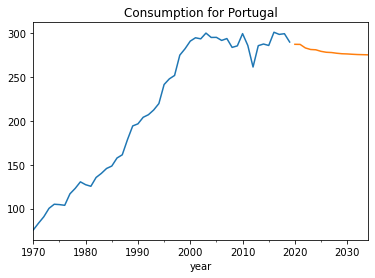

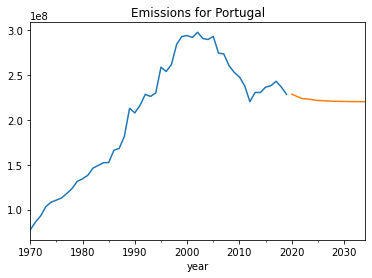

In [10]:
def get_arima(dataframe,country, ad_points = 15):
    copy = df.copy()
    copy['total_consumption'] = copy[cols].sum(axis=1).round(3)
    #model consumption
    data = copy[copy['country'] == country]['total_consumption']
    
    model = ARIMA(data.iloc[:-2], order=(3, 1, 0))
    model_fit = model.fit()

    yhat = model_fit.predict(len(data)-2, len(data) + ad_points-3, typ = 'levels')
    
    #plot
    data[:-2].plot()
    yhat.plot()
    plt.title(f'Consumption for {country}')
    plt.show()
    #-------------------------------------------------------
    #model emissions
    data = copy[copy['country'] == country]['emissions']
    
    model = ARIMA(data.iloc[:-2], order=(3, 1, 0))
    model_fit = model.fit()

    yhat = model_fit.predict(len(data)-2, len(data) + ad_points-3, typ = 'levels')
    
    #------------------------------------------
    data[:-2].plot()
    yhat.plot()
    plt.title(f'Emissions for {country}')
    plt.show()
    

get_arima(df,'Portugal')

In [39]:
def get_arima(dataframe,country, ad_points = 15):
    copy = df.copy()
    copy['total_consumption'] = copy[cols].sum(axis=1).round(3)
    #model consumption
    data = copy[copy['country'] == country]['total_consumption']
    
    model = ARIMA(data.iloc[:-2], order=(3, 1, 0))
    model_fit = model.fit()

    yhat = model_fit.predict(len(data)-2, len(data) + ad_points-3, typ = 'levels')
    
    #plot
    '''data[:-2].plot()
    #yhat.plot()
    #plt.title(f'Consumption for {country}')
    #plt.show()'''
    chart_cons = alt.Chart(data[:-2].reset_index()).mark_line().encode(
                x=alt.X('year:T', axis=alt.Axis(title="Year")),
                y=alt.Y("total_consumption:Q", axis=alt.Axis(title="Total consumption"))
    ).properties(
                    title=f"Total energy consumption for {country}",
                    width=350,
                    height=300
    )
    #-------------------------------------------------------
    #model emissions
    data_ = copy[copy['country'] == country]['emissions']
    
    model = ARIMA(data_.iloc[:-2], order=(3, 1, 0))
    model_fit = model.fit()

    yhat = model_fit.predict(len(data_)-2, len(data_) + ad_points-3, typ = 'levels')
    
    #------------------------------------------
    '''data[:-2].plot()
    yhat.plot()
    plt.title(f'Emissions for {country}')
    plt.show()'''
    chart_ems = alt.Chart(data_[:-2].reset_index()).mark_line().encode(
                x=alt.X('year:T', axis=alt.Axis(title="Year")),
                y=alt.Y("emissions:Q", axis=alt.Axis(title="Total emissions"))
        ).properties(
                    title=f"Emissions for {country}",
                    width=350,
                    height=300
    )
            
    return chart_cons | chart_ems
    
    

In [40]:
get_arima(df,'Portugal')

alt.HConcatChart(...)

In [193]:
#### Can't figure out how to plot with altair

In [158]:
def get_arima(dataframe,country, ad_points = 5):
    df['total_consumed'] = df[cols].sum(axis=1).round(3)
    #model
    data = df[df['country'] == country]['total_consumed']
    train = data.iloc[:-10]
    test = data.iloc[-10:]
    model = ARIMA(train, order=(3, 1, 0))
    model = model.fit()
    
    start = len(train)
    end = len(data) + additional_points-1

    pred = model.predict(start = start, end = end, typ = 'levels')
    #----------------------------------------------
    #Plot
# Get selection of columns for interactive legend of chart        
    selection = alt.selection_multi(fields= [country], bind='legend')
                        
    # Creation of chart with altair
    chart = alt.Chart(pred.reset_index()).mark_line().encode(
        x=alt.X('year:T', axis=alt.Axis(title="Year")),
        y=alt.Y("total_consumed:Q", axis=alt.Axis(title="Amount of Consumption", labelExpr="datum.value + 'TWh'")),
        color="country:N",
        opacity=alt.condition(selection, alt.value(1), alt.value(0.2)), #Changes opacity if source is selected in legend
        tooltip=[
            alt.Tooltip(title="Country", field="country"),
            alt.Tooltip(title="Year", field="year"),
            alt.Tooltip(title="Consumption in TWh", field="total_consumption"),
            ]
        ).properties(
            title=f"Total consumption for",
            width=800,
            height=300
        ).add_selection(
            selection
        )
                
    return chart
    
    
    

In [159]:
get_arima(df,'Portugal')

2012-01-01    286.119652
2013-01-01    289.584550
2014-01-01    284.991556
2015-01-01    284.827038
2016-01-01    285.454881
2017-01-01    283.747945
2018-01-01    283.470264
2019-01-01    283.406494
2020-01-01    282.685555
2021-01-01    282.436974
2022-01-01    282.257709
2023-01-01    281.905749
2024-01-01    281.717735
2025-01-01    281.560257
2026-01-01    281.365667
Freq: AS-JAN, Name: predicted_mean, dtype: float64

AttributeError: 'function' object has no attribute 'encode'

In [104]:
data = df[df['country'] == 'Portugal']['total_consumed']

In [122]:
train = data.iloc[:-10]
test = data.iloc[-10:]

print(train.shape, test.shape)

(42,) (10,)
